#Traditional ML Models

In [34]:
!pip install sentence-transformers --quiet

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import re
import string
from sentence_transformers import SentenceTransformer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay



In [36]:
# Mount Drive to import dataset
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


##Data Exploration

In [37]:
# Load your dataset (adjust path if needed)
df = pd.read_csv("/content/drive/MyDrive/AI dataset/CEAS_08.csv")

# Keep ONLY the required columns for modeling
required_cols = ['body', 'label']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("WARNING: Missing required columns:", missing)

df = (
    df[[c for c in required_cols if c in df.columns]]
    .dropna(subset=[c for c in required_cols if c in df.columns])
    .reset_index(drop=True)
)

target  = 'label'
labels  = ['Spam','Ham']
features = [i for i in df.columns.values if i not in [target]]

original_df = df.copy(deep=True)
display(df.head())

,body,label
0,"Buck up, your troubles caused by small dimensi...",1
1,\nUpgrade your sex and pleasures with these te...,1
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1
3,Would anyone object to removing .so from this ...,0
4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    39154 non-null  object
 1   label   39154 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 611.9+ KB


In [39]:
df.nunique().sort_values()

,0
label,2
body,39154


In [40]:
# Label mapping
label_map = {0: 'Ham', 1: 'Spam'}

# Count values
label_counts = df['label'].value_counts().sort_index()  # sort by 0,1

# Create display names like "0 (Ham)" or "1 (Spam)"
labels = [label_map[i] for i in label_counts.index]

# Show counts with names
for lbl, count in zip(display_labels, label_counts.values):
    print(f"{lbl}: {count}")

0 (Ham): 17312
1 (Spam): 21842


In [41]:
for i in range (0,2):
    print("Email #"+str(i+1))
    spam_email = df[df['label'] == 1]['body'].iloc[i]
    print(spam_email+"\n")

Email #1
Buck up, your troubles caused by small dimension will soon be over!
Become a lover no woman will be able to resist!
http://whitedone.com/


come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.

Email #2

Upgrade your sex and pleasures with these techniques http://www.brightmade.com






In [42]:
for i in range (0,2):
    print("Email #"+str(i+1))
    legitimate_email = df[df['label'] == 0]['body'].iloc[i]
    print(legitimate_email+"\n")

Email #1
Would anyone object to removing .so from this list?  The .so TLD is  
basically dead and we've found that lots of bogus domains like lib*.so  
are being caught by this.  Also sometimes you'll have spammers who are  
putting in gibberish or funny punctuation and you'll get sentences  
like 'blah blah.So this is'.  It also occurs with a couple of other  
domains but .so is by far the worst.

For more info on the .so domain you can read about it here: http://en.wikipedia.org/wiki/.so_%28domain_name%29

Michael

On Feb 7, 2008, at 9:23 PM, wrzzpv@apache.org wrote:

> Author: sidney
> Date: Thu Feb  7 19:22:58 2008
> New Revision: 619753
>
> URL: http://svn.apache.org/viewvc?rev=619753&view=rev
> Log:
> bug 5813: correct TLD lookup to match current ICANN list and add all  
> TLDs to regression tests
>
> Modified:
>    spamassassin/trunk/lib/Mail/SpamAssassin/PerMsgStatus.pm
>    spamassassin/trunk/lib/Mail/SpamAssassin/Util/ 
> RegistrarBoundaries.pm
>    spamassassin/trunk/t/uri_t

## Exploratory Data Analysis (EDA)

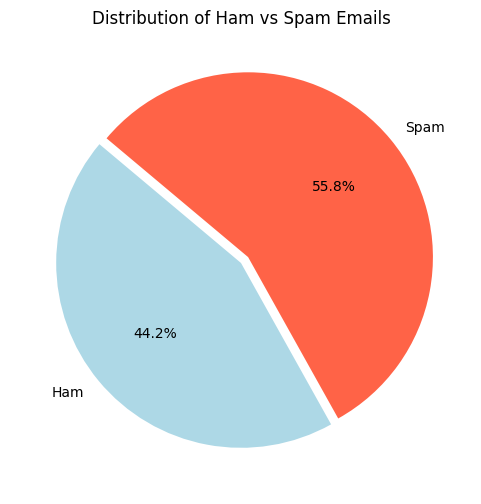

In [43]:
# Pie chart
plt.figure(figsize=(6, 6))
colors = ['lightblue', 'tomato']
plt.pie(
    label_counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=(0, 0.05)
)
plt.title("Distribution of Ham vs Spam Emails")
plt.show()

##Data Preprocessing

In [44]:
# Set of English stopwords
ENGLISH_STOP_WORDS = set(stopwords.words('english'))

# Enhanced text cleaning function
def clean_text(text):
    text = str(text).lower()  # Lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]  # Remove stopwords
    text = ' '.join(tokens)  # Rejoin for vectorizers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Apply cleaning with progress bar
tqdm.pandas(desc="Cleaning text")
df['clean_body'] = df['body'].progress_apply(clean_text)

# Quick look at the results
df[['body', 'clean_body']].head()

Cleaning text:   0%|          | 0/39154 [00:00<?, ?it/s]

,body,clean_body
0,"Buck up, your troubles caused by small dimensi...",buck troubles caused small dimension soon beco...
1,\nUpgrade your sex and pleasures with these te...,upgrade sex pleasures techniques
2,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,daily top 10 cnncom top videos stories aug 1 2...
3,Would anyone object to removing .so from this ...,would anyone object removing list tld basicall...
4,\nWelcomeFastShippingCustomerSupport\nhttp://7...,welcomefastshippingcustomersupport


In [45]:
# Check the data again
for i in range (0,2):
    print("Email #"+str(i+1))
    spam_email = df[df['label'] == 1]['clean_body'].iloc[i]
    print(spam_email+"\n")

Email #1
buck troubles caused small dimension soon become lover woman able resist come even nazi tanks rolling streets dreamersphilosopher journalist still surei

Email #2
upgrade sex pleasures techniques



In [46]:
for i in range (0,2):
    print("Email #"+str(i+1))
    spam_email = df[df['label'] == 0]['clean_body'].iloc[i]
    print(spam_email+"\n")

Email #1
would anyone object removing list tld basically dead weve found lots bogus domains like libso caught also sometimes youll spammers putting gibberish funny punctuation youll get sentences like blah blahso also occurs couple domains far worst info domain read michael feb 7 2008 923 pm wrzzpvapacheorg wrote author sidney date thu feb 7 192258 2008 new revision 619753 url log bug 5813 correct tld lookup match current icann list add tlds regression tests modified spamassassintrunklibmailspamassassinpermsgstatuspm spamassassintrunklibmailspamassassinutil registrarboundariespm spamassassintrunkturitextt modified spamassassintrunklibmailspamassassinpermsgstatuspm url spamassassintrunklibmailspamassassinpermsgstatuspm original spamassassintrunklibmailspamassassinpermsgstatuspm thu feb 7 192258 2008 166517 166517 regexps finding plain text nonscheme hostnames valid tlds list validtlds utilregistrarboundariespm regexpoptimize optimized regexp accurate 20050318 regexplist optimized regexp

## Data Manipulation

In [47]:
# Sentence BERT
# Load a pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast, good for ~40k emails

# Use tqdm for progress bar
tqdm.pandas(desc="Encoding emails")

# 'clean_text' is your preprocessed column
embeddings = df['clean_body'].progress_apply(lambda x: model.encode(x))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding emails:   0%|          | 0/39154 [00:00<?, ?it/s]

In [48]:
X = np.vstack(embeddings.values)
y = df['label']

## Feature Selection/Extraction


In [49]:
# Scale embeddings first (important before PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=100, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X.shape)
print("After PCA:", X_pca.shape)

Original shape: (39154, 384)
After PCA: (39154, 100)


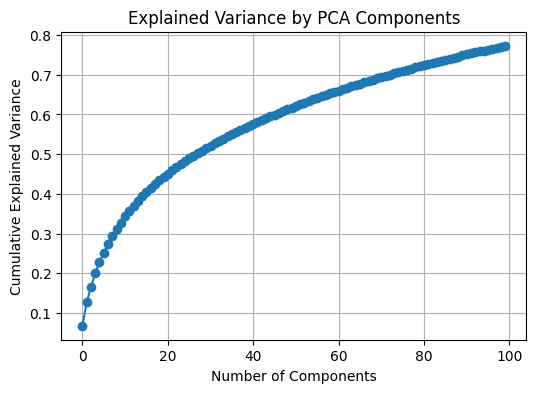

In [50]:
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

## Training/Testing Separation

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

## Prediction Models

In [53]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report
from sklearn.linear_model import SGDClassifier, LogisticRegression

# --- Batch generator for tqdm ---
def batch_generator(X, y, batch_size=512):
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

# --- Naive Bayes with progress bar ---
nb = GaussianNB()
print("Training Naive Bayes:")
for X_batch, y_batch in tqdm(batch_generator(X_train, y_train, batch_size=512),
                            total=int(np.ceil(len(X_train)/512))):
    nb.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

nb_preds = nb.predict(X_test)
print("Naive Bayes F1:", f1_score(y_test, nb_preds, average='weighted'))
print(classification_report(y_test, nb_preds))

# --- Random Forest with progress bar (manual simulation) ---
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
print("Training Random Forest:")
for i in tqdm(range(rf.n_estimators)):
    rf.set_params(n_estimators=i+1)
    rf.fit(X_train, y_train)  # fit one tree at a time (simulation)
rf_preds = rf.predict(X_test)
print("Random Forest F1:", f1_score(y_test, rf_preds, average='weighted'))
print(classification_report(y_test, rf_preds))

# --- LinearSVC via SGD with progress bar ---
svm = SGDClassifier(loss='hinge', max_iter=1, tol=None, random_state=42)
print("Training SVM:")
for X_batch, y_batch in tqdm(batch_generator(X_train, y_train, batch_size=512),
                            total=int(np.ceil(len(X_train)/512))):
    svm.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

svm_preds = svm.predict(X_test)
print("SVM F1:", f1_score(y_test, svm_preds, average='weighted'))
print(classification_report(y_test, svm_preds))

# --- Logistic Regression with progress bar ---
log_reg = LogisticRegression(max_iter=512, random_state=42)
print("Training Logistic Regression:")
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict(X_test)
print("Logistic Regression F1:", f1_score(y_test, log_preds, average='weighted'))
print(classification_report(y_test, log_preds))

Training Naive Bayes:


  0%|          | 0/62 [00:00<?, ?it/s]

Naive Bayes F1: 0.8752637306981045
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3462
           1       0.94      0.83      0.88      4369

    accuracy                           0.87      7831
   macro avg       0.88      0.88      0.87      7831
weighted avg       0.88      0.87      0.88      7831

Training Random Forest:


  0%|          | 0/100 [00:00<?, ?it/s]

Random Forest F1: 0.9844245604731979
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3462
           1       0.99      0.98      0.99      4369

    accuracy                           0.98      7831
   macro avg       0.98      0.98      0.98      7831
weighted avg       0.98      0.98      0.98      7831

Training SVM:


  0%|          | 0/62 [00:00<?, ?it/s]

SVM F1: 0.9659694075880314
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      3462
           1       0.96      0.98      0.97      4369

    accuracy                           0.97      7831
   macro avg       0.97      0.96      0.97      7831
weighted avg       0.97      0.97      0.97      7831

Training Logistic Regression:
Logistic Regression F1: 0.9731735906242115
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3462
           1       0.97      0.98      0.98      4369

    accuracy                           0.97      7831
   macro avg       0.97      0.97      0.97      7831
weighted avg       0.97      0.97      0.97      7831



Naive Bayes Metrics
Precision: 88.38%
Recall: 87.49%
F1 Score: 87.53%
Accuracy: 87.49%


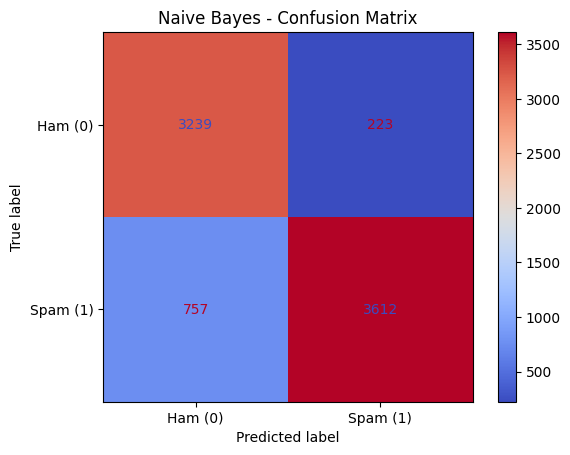

Random Forest Metrics
Precision: 98.44%
Recall: 98.44%
F1 Score: 98.44%
Accuracy: 98.44%


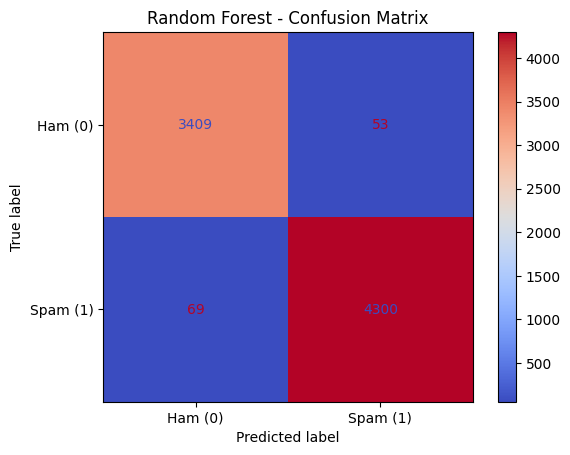

SVM via SGDClassifier Metrics
Precision: 96.63%
Recall: 96.60%
F1 Score: 96.60%
Accuracy: 96.60%


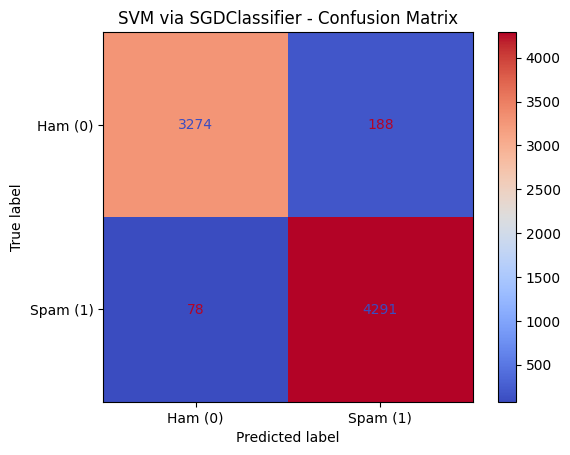

Logistic Regression Metrics
Precision: 97.32%
Recall: 97.32%
F1 Score: 97.32%
Accuracy: 97.32%


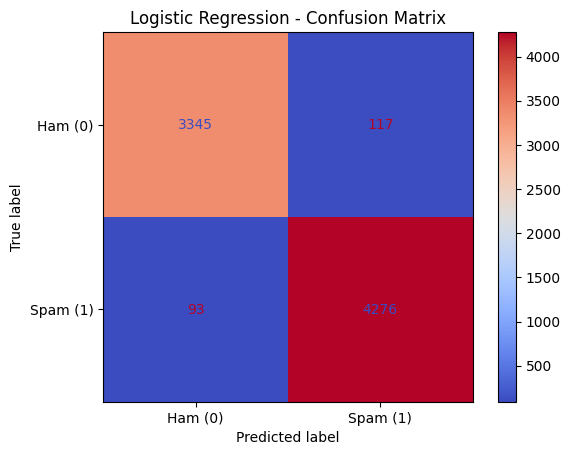

In [54]:
# Function to compute and display all metrics nicely
def show_metrics(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted') * 100
    recall = recall_score(y_true, y_pred, average='weighted') * 100
    f1 = f1_score(y_true, y_pred, average='weighted') * 100
    acc = accuracy_score(y_true, y_pred) * 100

    print(f"{model_name} Metrics")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")
    print(f"Accuracy: {acc:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham (0)', 'Spam (1)'])
    disp.plot(cmap='coolwarm')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# ---- Run metrics for all models ----
show_metrics(y_test, nb_preds, "Naive Bayes")
show_metrics(y_test, rf_preds, "Random Forest")
show_metrics(y_test, svm_preds, "SVM via SGDClassifier")
show_metrics(y_test, log_preds, "Logistic Regression")